
# 🌾 Kaggle Paddy Explore Dataset 

Take a look at the metadata and data

## 1) Setup

In [18]:

# If needed:
# !pip install -q timm pandas

import os, random
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import timm
from torchvision import transforms

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

DATA_DIR = Path("./data/") 
TRAIN_CSV = DATA_DIR / 'train.csv'
TRAIN_IMG_ROOT = DATA_DIR   / 'train_images'
assert TRAIN_CSV.exists(), f"Missing {TRAIN_CSV}"
assert TRAIN_IMG_ROOT.exists(), f"Missing {TRAIN_IMG_ROOT} (folder of label subdirs)"



Device: cuda


## There is a lot of meta data.  Is there a correlation between it and the target (label)

In [19]:
import pandas as pd
csv_path = DATA_DIR / "train.csv"
if not csv_path.exists():
    csv_candidates = list(DATA_DIR.glob("*.csv"))
    csv_path = csv_candidates[0] if csv_candidates else None

if csv_path is None:
    raise FileNotFoundError(f"No CSV file found in {DATA_DIR}")

df = pd.read_csv(csv_path)
print(f"Loaded CSV: {csv_path} (rows={len(df)}, cols={len(df.columns)})")
print(df.head())

n_varieties = df['variety'].unique()
print(f"Number of unique varieties: {n_varieties}")

Loaded CSV: data/train.csv (rows=10407, cols=4)
     image_id                  label variety  age
0  100330.jpg  bacterial_leaf_blight   ADT45   45
1  100365.jpg  bacterial_leaf_blight   ADT45   45
2  100382.jpg  bacterial_leaf_blight   ADT45   45
3  100632.jpg  bacterial_leaf_blight   ADT45   45
4  101918.jpg  bacterial_leaf_blight   ADT45   45
Number of unique varieties: ['ADT45' 'IR20' 'KarnatakaPonni' 'Onthanel' 'Ponni' 'Surya' 'Zonal'
 'AndraPonni' 'AtchayaPonni' 'RR']


In [20]:
print(f'Number unique labels: {len(df.label.unique())}')
print(f'Number unique ages: {len(df.age.unique())}')
print(f'Number unique varieties: {len(df.variety.unique())}')

Number unique labels: 10
Number unique ages: 18
Number unique varieties: 10


Categorical vs Categorical: variety vs label
Contingency table shape: (10, 10)


label,bacterial_leaf_blight,bacterial_leaf_streak,bacterial_panicle_blight,blast,brown_spot,dead_heart,downy_mildew,hispa,normal,tungro
variety,,,,,,,,,,
ADT45,406,107,260,793,835,979,331,833,1457,991
AndraPonni,0,0,14,112,0,70,0,181,0,0
AtchayaPonni,0,0,0,27,0,0,55,340,0,39
IR20,10,0,0,22,0,82,0,0,0,0
KarnatakaPonni,10,35,0,533,110,113,121,66,0,0


Chi2=7077.03, p-value=0.000e+00, dof=81, n=10407
Cramér's V = 0.2749  (0=no association, 1=perfect association)


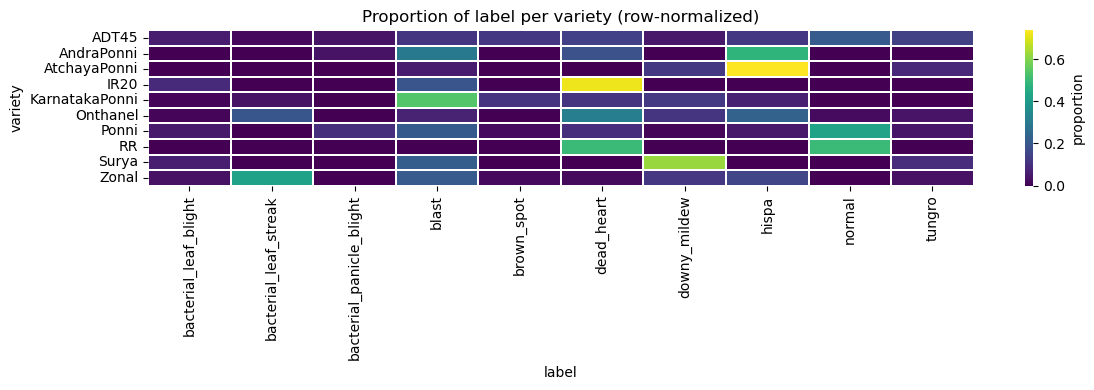

Categorical (by) vs Numeric: label -> age


,count,mean
label,,
normal,1764,62.056689
blast,1738,63.801496
hispa,1594,62.098494
dead_heart,1442,69.999307
tungro,1088,63.272059
brown_spot,965,64.981347
downy_mildew,620,60.319355
bacterial_leaf_blight,479,60.810021
bacterial_leaf_streak,380,62.986842


One-way ANOVA: F=157.729, p=5.926e-281
Kruskal-Wallis: H=1431.293, p=1.338e-302


/tmp/ipykernel_3366896/889966336.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col_a, y=col_b, data=df, order=summary.index, palette="Set3")


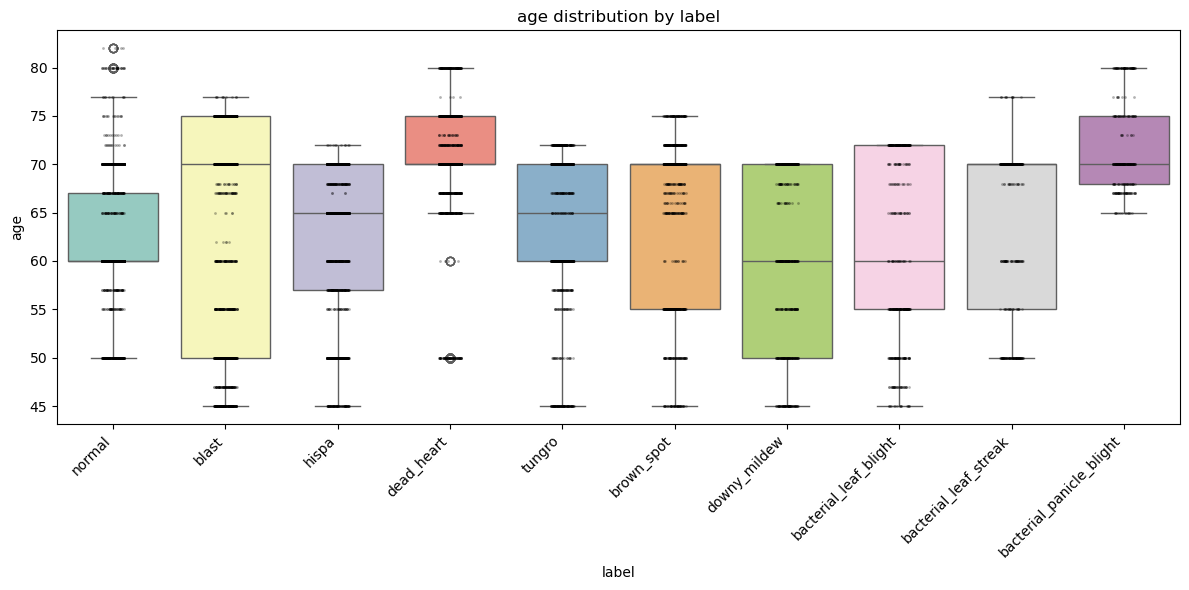

Contingency table shape: (10, 10)


label,bacterial_leaf_blight,bacterial_leaf_streak,bacterial_panicle_blight,blast,brown_spot,dead_heart,downy_mildew,hispa,normal,tungro
variety,,,,,,,,,,
ADT45,406,107,260,793,835,979,331,833,1457,991
AndraPonni,0,0,14,112,0,70,0,181,0,0
AtchayaPonni,0,0,0,27,0,0,55,340,0,39
IR20,10,0,0,22,0,82,0,0,0,0
KarnatakaPonni,10,35,0,533,110,113,121,66,0,0


Chi2=7077.03, p-value=0.000e+00, dof=81, n=10407
Cramér's V = 0.2749  (0=no association, 1=perfect association)

Top varieties by dominance of a single label:


,dominant_label,dominant_prop
variety,,
AtchayaPonni,hispa,0.737527
IR20,dead_heart,0.719298
Surya,downy_mildew,0.625000
KarnatakaPonni,blast,0.539474
RR,dead_heart,0.500000
AndraPonni,hispa,0.480106
Ponni,normal,0.427702
Zonal,bacterial_leaf_streak,0.423559
Onthanel,dead_heart,0.313390


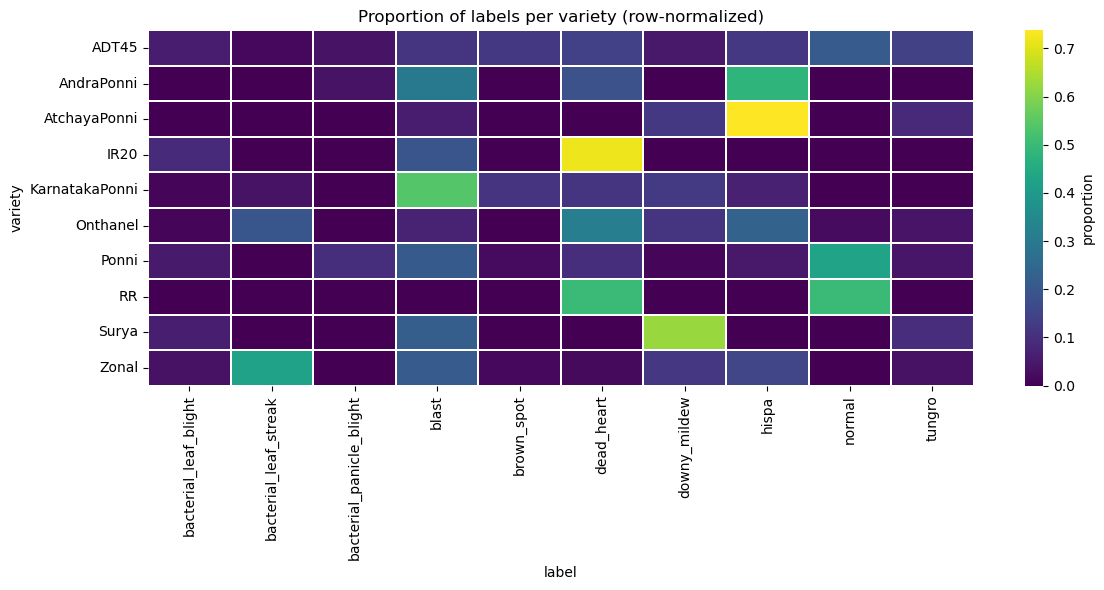

In [21]:
import seaborn as sns
from scipy.stats import chi2_contingency
from math import sqrt
from scipy.stats import f_oneway, kruskal
import matplotlib.pyplot as plt

# Investigate relationship between `label` and `variety`

def investigate_relation(df, col_a, col_b):
    """
    Quick investigation for:
     - categorical vs categorical: chi2 + Cramér's V + heatmap of proportions
     - categorical (col_a) vs numeric (col_b): group stats + ANOVA/Kruskal + boxplot
    """

    # detect numeric vs categorical
    is_b_numeric = pd.api.types.is_numeric_dtype(df[col_b])
    is_a_numeric = pd.api.types.is_numeric_dtype(df[col_a])

    if not is_b_numeric and not is_a_numeric:
        # categorical vs categorical
        print(f"Categorical vs Categorical: {col_a} vs {col_b}")
        cont = pd.crosstab(df[col_a], df[col_b])
        print("Contingency table shape:", cont.shape)
        display(cont.head())

        chi2, p, dof, expected = chi2_contingency(cont.values)
        n = cont.values.sum()
        min_dim = min(cont.shape)
        cramers_v = sqrt(chi2 / (n * (min_dim - 1))) if min_dim > 1 else 0.0
        print(f"Chi2={chi2:.2f}, p-value={p:.3e}, dof={dof}, n={n}")
        print(f"Cramér's V = {cramers_v:.4f}  (0=no association, 1=perfect association)")

        prop_by_a = cont.div(cont.sum(axis=1), axis=0)
        plt.figure(figsize=(12, max(4, prop_by_a.shape[0]*0.25)))
        sns.heatmap(prop_by_a, cmap="viridis", cbar_kws={'label': 'proportion'}, linewidths=0.2)
        plt.title(f"Proportion of {col_b} per {col_a} (row-normalized)")
        plt.xlabel(col_b)
        plt.ylabel(col_a)
        plt.tight_layout()
        plt.show()
        return

    # treat case: col_a categorical, col_b numeric (common: label vs age)
    if not is_a_numeric and is_b_numeric:
        print(f"Categorical (by) vs Numeric: {col_a} -> {col_b}")
        groups = df.groupby(col_a)[col_b].apply(lambda s: s.dropna().values)
        counts = groups.map(len).sort_values(ascending=False)
        means = df.groupby(col_a)[col_b].mean().sort_values(ascending=False)
        summary = pd.DataFrame({'count': counts, 'mean': means}).fillna(0).sort_values('count', ascending=False)
        display(summary.head(20))

        # ANOVA (requires >=2 groups with >0 samples)
        valid_groups = [g for g in groups if len(g) > 0]
        if len(valid_groups) >= 2:
            try:
                f_stat, p_val = f_oneway(*valid_groups)
                print(f"One-way ANOVA: F={f_stat:.3f}, p={p_val:.3e}")
            except Exception as e:
                print("ANOVA failed:", e)
            try:
                kw_stat, kw_p = kruskal(*valid_groups)
                print(f"Kruskal-Wallis: H={kw_stat:.3f}, p={kw_p:.3e}")
            except Exception as e:
                print("Kruskal-Wallis failed:", e)
        else:
            print("Not enough groups for ANOVA/Kruskal.")

        # boxplot + swarm
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=col_a, y=col_b, data=df, order=summary.index, palette="Set3")
        sns.stripplot(x=col_a, y=col_b, data=df, order=summary.index, color='k', size=2, alpha=0.3)
        plt.xticks(rotation=45, ha='right')
        plt.title(f"{col_b} distribution by {col_a}")
        plt.tight_layout()
        plt.show()
        return

    # fallback: numeric vs categorical (swap)
    if is_a_numeric and not is_b_numeric:
        # reuse previous logic by swapping
        investigate_relation(df, col_b, col_a)
        return

    # both numeric or other unknown combination
    print(f"Unhandled combination: {col_a} (numeric={is_a_numeric}), {col_b} (numeric={is_b_numeric})")
    print("Showing simple correlation if both numeric:")
    if is_a_numeric and is_b_numeric:
        corr = df[[col_a, col_b]].corr().iloc[0,1]
        print(f"Pearson correlation: {corr:.4f}")
        sns.scatterplot(x=col_a, y=col_b, data=df, alpha=0.5)
        plt.tight_layout()
        plt.show()


# Run investigations requested
investigate_relation(df, 'variety', 'label')   # categorical vs categorical
investigate_relation(df, 'label', 'age')       # label (categorical) vs age (numeric)
cont = pd.crosstab(df['variety'], df['label'])
print("Contingency table shape:", cont.shape)
display(cont.head())

# Chi-squared test + Cramér's V (effect size for nominal association)
chi2, p, dof, expected = chi2_contingency(cont.values)
n = cont.values.sum()
min_dim = min(cont.shape)
cramers_v = sqrt(chi2 / (n * (min_dim - 1))) if min_dim > 1 else 0.0

print(f"Chi2={chi2:.2f}, p-value={p:.3e}, dof={dof}, n={n}")
print(f"Cramér's V = {cramers_v:.4f}  (0=no association, 1=perfect association)")

# Per-variety dominant label and its proportion
prop_by_var = cont.div(cont.sum(axis=1), axis=0)  # row-normalized
dominant = prop_by_var.max(axis=1).sort_values(ascending=False)
dominant_label = prop_by_var.idxmax(axis=1)
summary = pd.DataFrame({
    'dominant_label': dominant_label,
    'dominant_prop': dominant
}).sort_values('dominant_prop', ascending=False)

print("\nTop varieties by dominance of a single label:")
display(summary.head(10))

# Heatmap of row-normalized proportions (variety vs label)
plt.figure(figsize=(12, max(6, cont.shape[0]*0.25)))
sns.heatmap(prop_by_var, cmap="viridis", cbar_kws={'label': 'proportion'}, linewidths=0.2)
plt.title("Proportion of labels per variety (row-normalized)")
plt.xlabel("label")
plt.ylabel("variety")
plt.tight_layout()
plt.show()

In [23]:

MODEL_NAME = 'convnext_tiny'
cfg = timm.data.resolve_data_config({}, model=MODEL_NAME)
train_tfms = timm.data.create_transform(**cfg, is_training=True, hflip=0.5, auto_augment=None)
valid_tfms = timm.data.create_transform(**cfg, is_training=False)

# Prepare train/validation split:
# - load the main CSV, shuffle indices, and reserve `val_frac` portion for validation
# - write two temporary CSVs (train_split.csv, valid_split.csv) consumed by the Dataset
# - create Dataset instances with timm transforms for training/validation
# (Uses TRAIN_CSV, DATA_DIR, TRAIN_IMG_ROOT, PaddyMultitaskDataset defined above)

df = pd.read_csv(TRAIN_CSV)
indices = np.arange(len(df)); np.random.shuffle(indices)
val_frac = 0.1; n_val = max(1, int(len(indices) * val_frac))
val_idx = indices[:n_val]; train_idx = indices[n_val:]

train_csv_tmp = DATA_DIR / 'train_split.csv'
val_csv_tmp   = DATA_DIR / 'valid_split.csv'
df.iloc[train_idx].to_csv(train_csv_tmp, index=False)
df.iloc[val_idx].to_csv(val_csv_tmp,   index=False)

train_ds = PaddyMultitaskDataset(train_csv_tmp, TRAIN_IMG_ROOT, transform=train_tfms)
valid_ds = PaddyMultitaskDataset(val_csv_tmp,   TRAIN_IMG_ROOT, transform=valid_tfms)

print('Label classes:', train_ds.labels)
print('Variety classes:', train_ds.varieties)
print('Train/Valid sizes:', len(train_ds), len(valid_ds))


Label classes: ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']
Variety classes: ['ADT45', 'AndraPonni', 'AtchayaPonni', 'IR20', 'KarnatakaPonni', 'Onthanel', 'Ponni', 'RR', 'Surya', 'Zonal']
Train/Valid sizes: 9367 1040


In [24]:
num_classes=len(train_ds.labels)  # main task
num_varieties=len(train_ds.varieties)  # auxiliary task

## 4) DataLoaders

In [25]:

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True)

xb, y_var, y_age, y_lbl = next(iter(train_loader))
print('Batch shapes:', xb.shape, y_var.shape, y_age.shape, y_lbl.shape)


Batch shapes: torch.Size([64, 3, 224, 224]) torch.Size([64]) torch.Size([64]) torch.Size([64])


## 5) Multi‑head model (`convnext_tiny` backbone)

In [26]:

class MultiHeadNet(nn.Module):
    def __init__(self, model_name: str, num_label_classes: int, num_variety_classes: int, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='avg')
        feat_dim = self.backbone.num_features
        self.head_label   = nn.Linear(feat_dim, num_label_classes)
        self.head_variety = nn.Linear(feat_dim, num_variety_classes)
        self.head_age     = nn.Linear(feat_dim, 1)

    def forward(self, x):
        feats = self.backbone(x)
        logits_label   = self.head_label(feats)
        logits_variety = self.head_variety(feats)
        age_pred       = self.head_age(feats).squeeze(1)
        return {'label': logits_label, 'variety': logits_variety, 'age': age_pred}

model = MultiHeadNet(MODEL_NAME, train_ds.num_label_classes, train_ds.num_variety_classes, pretrained=True).to(device)

for p in model.backbone.parameters():
    p.requires_grad = False
print('Trainable params (heads only):', sum(p.numel() for p in model.parameters() if p.requires_grad))


Trainable params (heads only): 16149


In [27]:
#make sure just training the last layer
for name, p in model.named_parameters():
    print (f'Name={name},p.shape={p.shape}, p.requires_grad = {p.requires_grad}')


Name=backbone.stem.0.weight,p.shape=torch.Size([96, 3, 4, 4]), p.requires_grad = False
Name=backbone.stem.0.bias,p.shape=torch.Size([96]), p.requires_grad = False
Name=backbone.stem.1.weight,p.shape=torch.Size([96]), p.requires_grad = False
Name=backbone.stem.1.bias,p.shape=torch.Size([96]), p.requires_grad = False
Name=backbone.stages.0.blocks.0.gamma,p.shape=torch.Size([96]), p.requires_grad = False
Name=backbone.stages.0.blocks.0.conv_dw.weight,p.shape=torch.Size([96, 1, 7, 7]), p.requires_grad = False
Name=backbone.stages.0.blocks.0.conv_dw.bias,p.shape=torch.Size([96]), p.requires_grad = False
Name=backbone.stages.0.blocks.0.norm.weight,p.shape=torch.Size([96]), p.requires_grad = False
Name=backbone.stages.0.blocks.0.norm.bias,p.shape=torch.Size([96]), p.requires_grad = False
Name=backbone.stages.0.blocks.0.mlp.fc1.weight,p.shape=torch.Size([384, 96]), p.requires_grad = False
Name=backbone.stages.0.blocks.0.mlp.fc1.bias,p.shape=torch.Size([384]), p.requires_grad = False
Name=backb

In [28]:
print(model)

MultiHeadNet(
  (backbone): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (norm): Identity()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            (conv_dw): C

## 6) Loss functions & optimizer

In [29]:
lr=2e-3
criterion = {
    'label':   nn.CrossEntropyLoss(),
    'variety': nn.CrossEntropyLoss(),
    'age':     nn.SmoothL1Loss(beta=1.0)
}
loss_weights = {'label': 1.0, 'variety': 0.7, 'age': 0.5}
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)


## 7) Training / evaluation utilities

In [30]:

def compute_multitask_loss(outputs, targets, criteria, weights=None):
    total = 0.0
    for k in ['label', 'variety', 'age']:
        w = 1.0 if (weights is None or k not in weights) else weights[k]
        total = total + w * criteria[k](outputs[k], targets[k])
    return total

def train_one_epoch(model, loader, optimizer, criteria, device, weights=None):
    model.train()
    run_loss, n = 0.0, 0
    correct_label, correct_variety, total = 0, 0, 0
    for images, y_var, y_age, y_lbl in loader:
        images = images.to(device); y_lbl = y_lbl.to(device); y_var = y_var.to(device); y_age = y_age.to(device)
        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)  #only feeding in images
        loss = compute_multitask_loss(outputs, {'label': y_lbl, 'variety': y_var, 'age': y_age}, criteria, weights)
        loss.backward()
        optimizer.step()
        bs = images.size(0)
        run_loss += loss.item() * bs; n += bs; total += bs
        correct_label   += (outputs['label'].argmax(1) == y_lbl).sum().item()
        correct_variety += (outputs['variety'].argmax(1) == y_var).sum().item()
    return run_loss / n, correct_label / total, correct_variety / total

@torch.no_grad()
def evaluate(model, loader, criteria, device, weights=None):
    model.eval()
    run_loss, n = 0.0, 0
    correct_label, correct_variety, total, mae_age = 0, 0, 0, 0.0
    for images, y_var, y_age, y_lbl in loader:
        images = images.to(device); y_lbl = y_lbl.to(device); y_var = y_var.to(device); y_age = y_age.to(device)
        outputs = model(images)
        loss = compute_multitask_loss(outputs, {'label': y_lbl, 'variety': y_var, 'age': y_age}, criteria, weights)
        bs = images.size(0)
        run_loss += loss.item() * bs; n += bs; total += bs
        correct_label   += (outputs['label'].argmax(1) == y_lbl).sum().item()
        correct_variety += (outputs['variety'].argmax(1) == y_var).sum().item()
        mae_age         += torch.abs(outputs['age'] - y_age).sum().item()
    return run_loss / n, correct_label / total, correct_variety / total, mae_age / total


## 8) Train & validate (warm‑up on heads)

In [31]:

EPOCHS = 5
for ep in range(1, EPOCHS + 1):
    tr_loss, tr_acc_lbl, tr_acc_var = train_one_epoch(model, train_loader, optimizer, criterion, device, weights=loss_weights)
    va_loss, va_acc_lbl, va_acc_var, va_mae_age = evaluate(model, valid_loader, criterion, device, weights=loss_weights)
    print(f"epoch {ep:02d} | train loss {tr_loss:.4f} | val loss {va_loss:.4f} | "
          f"label acc {va_acc_lbl:.3f} | variety acc {va_acc_var:.3f} | age MAE {va_mae_age:.2f}")


epoch 01 | train loss 10.6307 | val loss 4.9809 | label acc 0.667 | variety acc 0.791 | age MAE 7.75
epoch 02 | train loss 5.0060 | val loss 4.2450 | label acc 0.754 | variety acc 0.851 | age MAE 6.87
epoch 03 | train loss 4.6135 | val loss 3.8558 | label acc 0.799 | variety acc 0.861 | age MAE 6.39
epoch 04 | train loss 4.3406 | val loss 3.7079 | label acc 0.779 | variety acc 0.866 | age MAE 6.09
epoch 05 | train loss 4.1502 | val loss 3.5346 | label acc 0.815 | variety acc 0.871 | age MAE 5.86


## 9) (Optional) Unfreeze & fine‑tune the backbone

In [32]:

for p in model.backbone.parameters():
    p.requires_grad = True

#dont just create a new optimizer, you will lose all the state in original one and your results will suffer
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr/10)

#make lr smaller for fine-tuning
# lr1=lr/10
lr1=2e-3/10

#change learning rate for fine-tuning
for g in optimizer.param_groups:
    g['lr'] = lr1

EPOCHS_FT = 5
for ep in range(1, EPOCHS_FT + 1):
    tr_loss, tr_acc_lbl, tr_acc_var = train_one_epoch(model, train_loader, optimizer, criterion, device, weights=loss_weights)
    va_loss, va_acc_lbl, va_acc_var, va_mae_age = evaluate(model, valid_loader, criterion, device, weights=loss_weights)
    print(f"[FT] epoch {ep:02d} | train loss {tr_loss:.4f} | val loss {va_loss:.4f} | "
          f"label acc {va_acc_lbl:.3f} | variety acc {va_acc_var:.3f} | age MAE {va_mae_age:.2f}")


[FT] epoch 01 | train loss 3.9991 | val loss 3.4629 | label acc 0.822 | variety acc 0.894 | age MAE 5.89
[FT] epoch 02 | train loss 3.9524 | val loss 3.4161 | label acc 0.840 | variety acc 0.896 | age MAE 5.84
[FT] epoch 03 | train loss 3.9610 | val loss 3.4136 | label acc 0.823 | variety acc 0.897 | age MAE 5.84
[FT] epoch 04 | train loss 3.9182 | val loss 3.3915 | label acc 0.827 | variety acc 0.905 | age MAE 5.80
[FT] epoch 05 | train loss 3.9264 | val loss 3.3615 | label acc 0.839 | variety acc 0.903 | age MAE 5.74


## 10) Save / Load

In [ ]:

torch.save(model.state_dict(), 'multitask_convnext_tiny_paddy.pth')
print('Saved to multitask_convnext_tiny_paddy.pth')
# model.load_state_dict(torch.load('multitask_convnext_tiny_paddy.pth', map_location=device))
# model.eval()


Saved to multitask_convnext_tiny_paddy.pth


: 